# How to optimize a QAOA implementation to run on specific Hardware

There are several strategies that can help squeeze out the best performance when running QAOA on real hadware. This notebook will walk you through the QAOA workflow and showcase how it can be optimized for a particular execution.


[OVERVIEW OF TRICKS THAT WILL BE EMPLOYED AND WHY]

## Pre-Requisites

We need to start with a QAOA problem definition, which is generally in the form of a problem graph.
In this example, we will import a pre-computed graph from a json file.

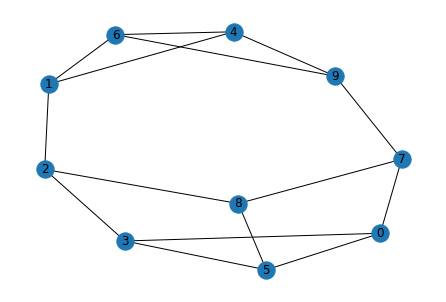

In [13]:
import json
import networkx as nx

graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))
graph = nx.from_edgelist(data["Original graph"])
nx.draw(graph, with_labels = True)

This graph has 10 nodes and 15 edges, and it can be encoded in 10 qubits.

In [14]:
num_qubits = len(graph.nodes)

## 1. Choose SWAP strategy

The first couple of steps of the workflow depend on the choice of qubit configuration we want, which will determine the kind of SWAP strategy that will be used, as well as the evaluation criteria for the backend to obtain the best subset of qubits.

In this example, we are fine if our qubits are configured to follow a **line**, so the reference SWAP strategy for 2-qubit commuting gates will be the following:

In [15]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])

## 2. Remap graph using SAT mapper

[Improve explanation] We can use the provided class for graph remapping (or implement our own). This step depends on step 1.

Map from old to new edges:  {0: 6, 1: 2, 2: 7, 3: 8, 4: 3, 5: 9, 6: 1, 7: 5, 8: 4, 9: 0}
Min SAT layers: 2


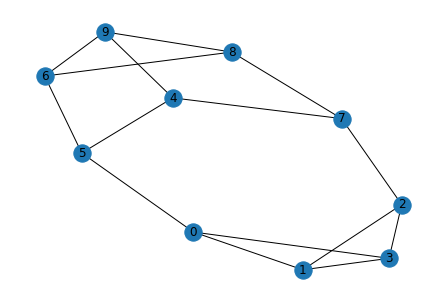

In [16]:
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper()
remapped_g, sat_map, min_sat_layers = sm.remap_graph_with_sat(graph=graph, swap_strategy=swap_strategy)

print("Map from old to new edges: ", sat_map)
print("Min SAT layers:", min_sat_layers)
nx.draw(remapped_g, with_labels = True)

## 3. Construct Hamiltonian from remapped graph (sum of Paulis)

In [17]:
from qopt_best_practices.utils import build_paulis
from qiskit.quantum_info import SparsePauliOp

pauli_list = build_paulis(remapped_g)
print(pauli_list)

# define a qiskit SparsePauliOp from the list of paulis
cost_operator = SparsePauliOp.from_list(pauli_list)
print(cost_operator)

[('IIIZZIIIII', 1.0), ('IZIZIIIIII', 1.0), ('ZIIZIIIIII', 1.0), ('IIIIZIIIIZ', 1.0), ('IIIIZZIIII', 1.0), ('IZZIIIIIII', 1.0), ('ZZIIIIIIII', 1.0), ('ZIIIIZIIII', 1.0), ('IIIIIIZIIZ', 1.0), ('IIIIIIIIZZ', 1.0), ('IIZIIZIIII', 1.0), ('IIZIIIIZII', 1.0), ('IIIIIIZZII', 1.0), ('IIIIIIIZZI', 1.0), ('IIIIIIZIZI', 1.0)]
SparsePauliOp(['IIIZZIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IIIIZIIIIZ', 'IIIIZZIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIZIIII', 'IIIIIIZIIZ', 'IIIIIIIIZZ', 'IIZIIZIIII', 'IIZIIIIZII', 'IIIIIIZZII', 'IIIIIIIZZI', 'IIIIIIZIZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## 4. Build QAOA circuit applying previously defined SWAP strategy

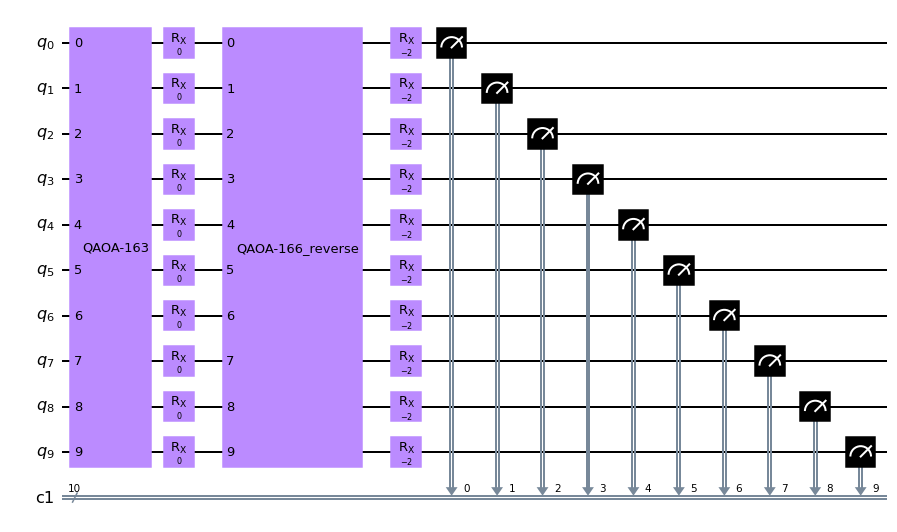

In [18]:
from qopt_best_practices.swap_strategies import create_qaoa_swap_circuit

theta = [1, 1, 0, 1]
qaoa_circ = create_qaoa_swap_circuit(cost_operator, theta, swap_strategy)
qaoa_circ.draw('mpl')

## 5. Find best subset of qubits to map circuit to a specific device

In [19]:
import rustworkx as rx
from qiskit.transpiler import CouplingMap

# define method to find all subsets of qubits
def find_lines(length: int, backend, *args) -> list[int]:

    coupling_map = CouplingMap(backend.configuration().coupling_map)
    paths, size = [], coupling_map.size()

    # picking the lines
    for node1 in range(size):
        for node2 in range(node1 + 1, size):
            paths.extend(
                rx.all_simple_paths(
                    coupling_map.graph,
                    node1,
                    node2,
                    min_depth=length,
                    cutoff=length)
            )

    return paths

# define metric to evaluate subsets --> 2 qubit gate fidelity
def evaluate_fidelity(path: list[int], backend, edges) -> float:

    two_qubit_fidelity = {}
    props = backend.properties()
    if "cx" in backend.configuration().basis_gates:
        gate_name = "cx"
    elif "ecr" in backend.configuration().basis_gates:
        gate_name = "ecr"
    else:
        raise ValueError("Could not identify two-qubit gate")

    for edge in edges:
        try:
            cx_error = props.gate_error(gate_name, edge)

        except:  # pylint: disable=bare-except
            cx_error = props.gate_error(gate_name, edge[::-1])

        two_qubit_fidelity[tuple(edge)] = 1 - cx_error

    if not path or len(path) == 1:
        return 0.0

    fidelity = 1.0
    for idx in range(len(path) - 1):
        fidelity *= two_qubit_fidelity[(path[idx], path[idx + 1])]

    return fidelity


In [20]:
from qiskit.providers.fake_provider import FakeWashington
from qopt_best_practices.qubit_selection import  BackendEvaluator

backend = FakeWashington()
path_finder = BackendEvaluator(backend)

path, _ = path_finder.evaluate(num_qubits, subset_finder=find_lines, metric_eval=evaluate_fidelity)
print(path)

[30, 31, 32, 36, 51, 50, 49, 48, 47, 35]


## 6. Use subset to define initial layout

In [21]:
from qiskit.transpiler import Layout

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0]) # needs qaoa_circ

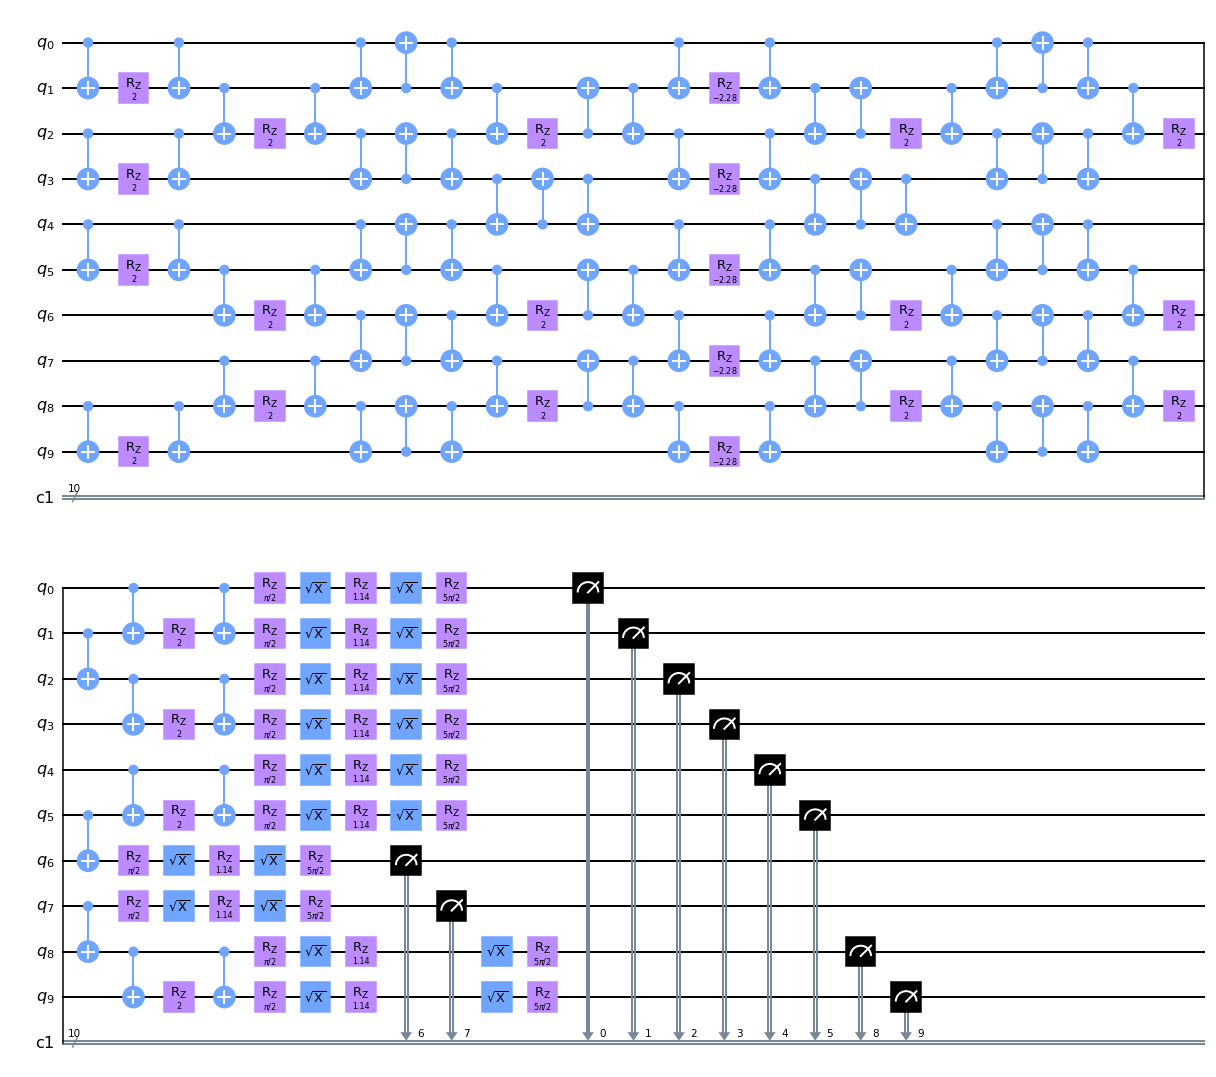

In [22]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)

# transpile to basis gates

from qiskit import transpile

basis_gates = ["rz", "sx", "x", "cx"]
#
# Now transpile to sx, rz, x, cx basis
qaoa_circ = transpile(qaoa_circ, basis_gates=basis_gates)
qaoa_circ.draw('mpl')

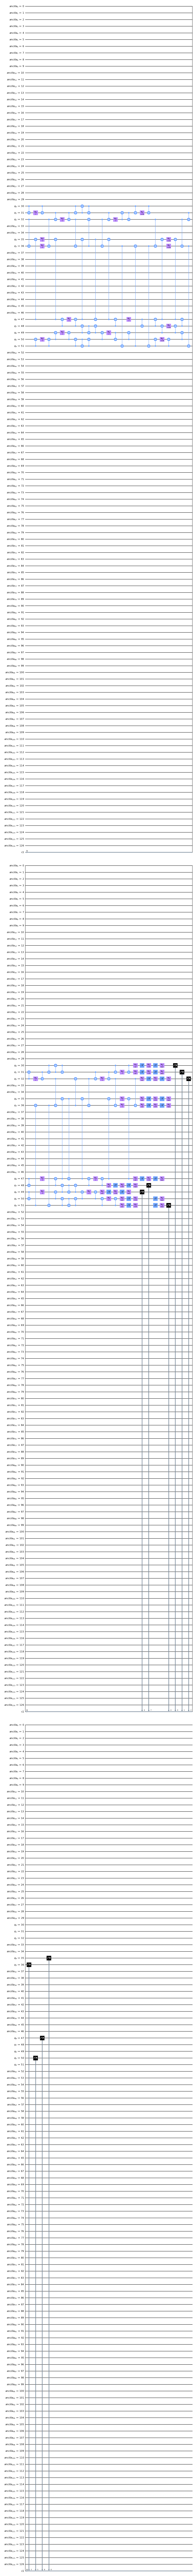

In [23]:

backend_cmap = CouplingMap(backend.configuration().coupling_map)
edge_coloring = {(idx, idx + 1): idx % 2 for idx in range(num_qubits)}

pass_manager_post = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Insert swap gates, map to initial_layout and finally enlarge with ancilla.
transpiled_circ = pass_manager_post .run(qaoa_circ)
transpiled_circ.draw('mpl')